In [2]:
import pyemu
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import sys
sys.path.insert(1, '../../modules')
# import modules
from Rouss import *
from Rouss3D import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [3]:
t_d ="master_glm"
case = "3D_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cond,cond,log,6,-3 to -2,-2,-3,0.25
irr__multiplier,irr__multiplier,log,14,-0.09691 to 0.30103,0.30103,-0.09691,0.099485
kp_pc_inst:0,kp_pc_inst:0,log,110,-1.30103 to 1.69897,1.69897,-1.30103,0.75
kp_q_inst:0,kp_q_inst:0,log,83,-2.30103 to 0.477121,0.477121,-2.30103,0.694538
pms__multiplier,pms__multiplier,log,1,-0.82506,1.47712,-1.30103,0.694538


[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

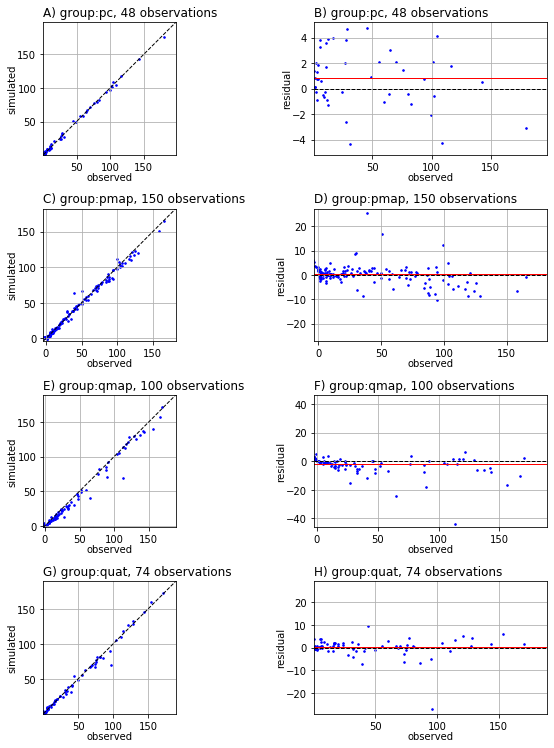

In [4]:
pst.plot(kind='1to1')

In [18]:
pst.svd_data.eigthresh = 5e-7
pst.control_data.noptmax = 7 # number of iterations (should be set to a great value (50))
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 4
pst.pestpp_options["glm_num_reals"] = 50 # how many draws
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case)
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case)
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:7, npar_adj:215, nnz_obs:222


In [19]:
# DO the inversion
m_d = "master_glm_run"
pyemu.os_utils.start_workers(t_d,"../../pestpp-glm.exe","{}.pst".format(case),num_workers=8,worker_root=".",
                             master_dir=m_d)

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

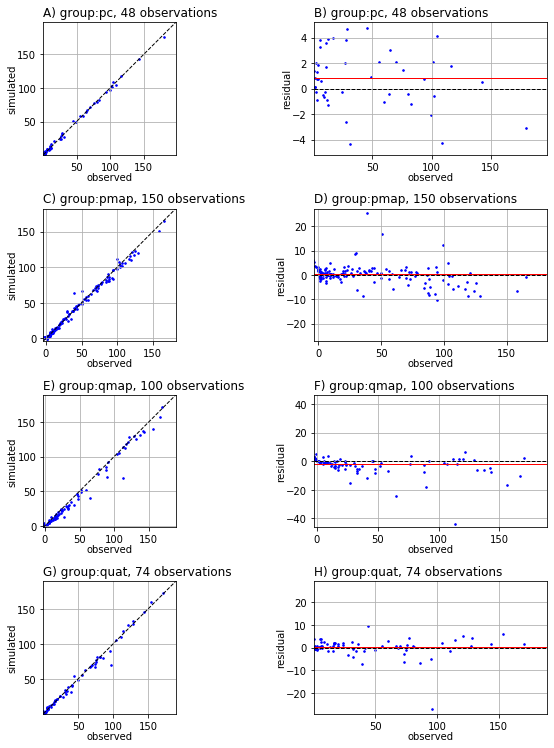

In [5]:
m_d = "master_glm_run"
pst_2 = pyemu.Pst(os.path.join(m_d,"{}.pst".format(case)))
pst_2.plot(kind="1to1")

8712.504440960474 {'pc': 258.42967183957956, 'pmap': 2529.5493832215466, 'qmap': 4652.479210221411, 'quat': 1272.046175677936} {'pc': 0.029661927129082763, 'pmap': 0.29033550575070777, 'qmap': 0.5340002110470681, 'quat': 0.1460023560731413}


[None,
 None,

<Figure size 576x756 with 0 Axes>

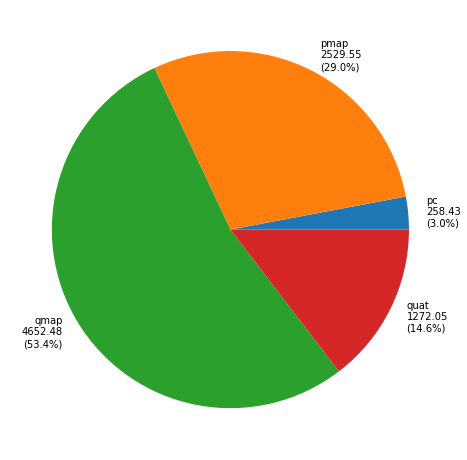

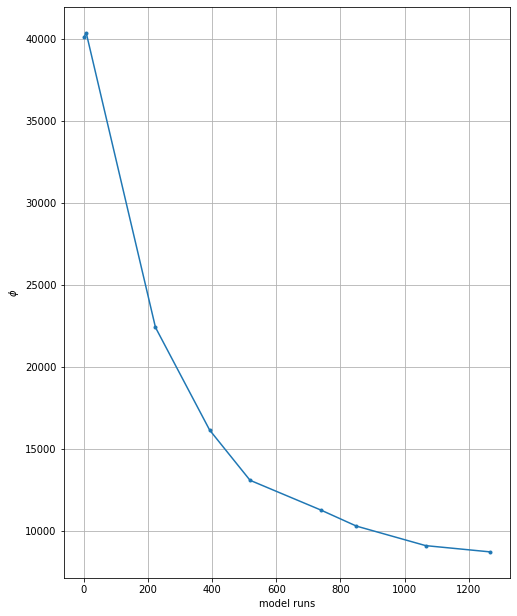

In [25]:
pst_2.plot()

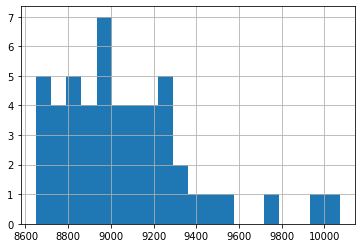

In [28]:
df = df=pd.read_csv(os.path.join(m_d,"{}.post.obsen.csv".format(case)),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

ax = oe.phi_vector.hist(bins=20)

In [29]:
dfp = df=pd.read_csv(os.path.join(m_d,"{}.par.usum.csv".format(case)),index_col=0)
dfp["post_mean"]

name
KP_Q_INST:0_I:15_J:135            -0.250952
KP_Q_INST:0_I:25_J:135             0.477121
KP_Q_INST:0_I:35_J:125            -1.911310
KP_Q_INST:0_I:35_J:135            -0.503547
KP_Q_INST:0_I:45_J:105             0.477121
                                     ...   
MULTIPLIER_IRR_INST:0_ZONE:9.0    -0.096910
MULTIPLIER_IRR_INST:0_ZONE:5.0    -0.096910
MULTIPLIER_IRR_INST:0_ZONE:11.0   -0.096910
MULTIPLIER_IRR_INST:0_ZONE:6.0    -0.096910
MULTIPLIER_CONST_PMS_INST:0       -0.825060
Name: post_mean, Length: 214, dtype: float64

(array([22.,  0.,  0.,  0.,  3.,  0.,  0.,  1.,  0.,  3.,  0.,  1.,  1.,
         1.,  5.,  3.,  4.,  1.,  2.,  1.,  1.,  6.,  2.,  3.,  2.,  7.,
         4.,  1.,  1., 35.]),
 array([-1.30103e+00, -1.20103e+00, -1.10103e+00, -1.00103e+00,
        -9.01030e-01, -8.01030e-01, -7.01030e-01, -6.01030e-01,
        -5.01030e-01, -4.01030e-01, -3.01030e-01, -2.01030e-01,
        -1.01030e-01, -1.03000e-03,  9.89700e-02,  1.98970e-01,
         2.98970e-01,  3.98970e-01,  4.98970e-01,  5.98970e-01,
         6.98970e-01,  7.98970e-01,  8.98970e-01,  9.98970e-01,
         1.09897e+00,  1.19897e+00,  1.29897e+00,  1.39897e+00,
         1.49897e+00,  1.59897e+00,  1.69897e+00]),
 <a list of 30 Patch objects>)

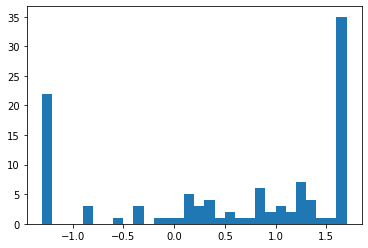

In [35]:
idx_kpq = [i for i in range(dfp.shape[0]) if "KP_PC" in dfp.index[i]]
plt.hist(dfp.reset_index().loc[idx_kpq]["post_mean"],bins=30)

In [66]:
10**dfp["post_stdev"]

name
KP_Q_INST:0_I:15_J:135             2.124350
KP_Q_INST:0_I:25_J:135             2.097862
KP_Q_INST:0_I:35_J:125             2.042857
KP_Q_INST:0_I:35_J:135             2.049047
KP_Q_INST:0_I:45_J:105             1.644425
                                     ...   
MULTIPLIER_IRR_INST:0_ZONE:9.0     1.164701
MULTIPLIER_IRR_INST:0_ZONE:5.0     1.164472
MULTIPLIER_IRR_INST:0_ZONE:11.0    1.148758
MULTIPLIER_IRR_INST:0_ZONE:6.0     1.160864
MULTIPLIER_CONST_PMS_INST:0        1.122168
Name: post_stdev, Length: 214, dtype: float64

In [53]:
#kriging standard dev
pst_2.parameter_data.parval1.iloc[:199] = 10**dfp["post_stdev"].values[:199]
pst_2.control_data.noptmax = 0 # one run
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)
kQstd = np.loadtxt(os.path.join(t_d,"kq.txt"))
kQstd[kQstd == kQstd[0,0]] = None
kPstd = np.loadtxt(os.path.join(t_d,"kpc.txt"))
kPstd[kPstd == kPstd[0,0]] = None

#kriging kmax
pst_2.parameter_data.parval1 = 10**dfp["post_upper_bound"].values
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)
kQmax = np.loadtxt(os.path.join(t_d,"kq.txt"))
kQmax[np.isnan(kQstd)] = None
kPmax = np.loadtxt(os.path.join(t_d,"kpc.txt"))
kPmax[np.isnan(kPstd)] = None

#kriging kmin
pst_2.parameter_data.parval1 = 10**dfp["post_lower_bound"].values
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)
kQmin = np.loadtxt(os.path.join(t_d,"kq.txt"))
kQmin[np.isnan(kQstd)] = None
kPmin = np.loadtxt(os.path.join(t_d,"kpc.txt"))
kPmin[np.isnan(kPstd)] = None

#kriging k to plot
pst_2.parameter_data.parval1 = 10**dfp["post_mean"].values
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)
kQ = np.log10(np.loadtxt(os.path.join(t_d,"kq.txt")))
kQ[np.isnan(kQstd)] = None
kP = np.log10(np.loadtxt(os.path.join(t_d,"kpc.txt")))
kP[np.isnan(kPstd)] = None

noptmax:0, npar_adj:214, nnz_obs:372
noptmax:0, npar_adj:214, nnz_obs:372
noptmax:0, npar_adj:214, nnz_obs:372
noptmax:0, npar_adj:214, nnz_obs:372


[Text(0.5, 1.0, 'Kmin log')]

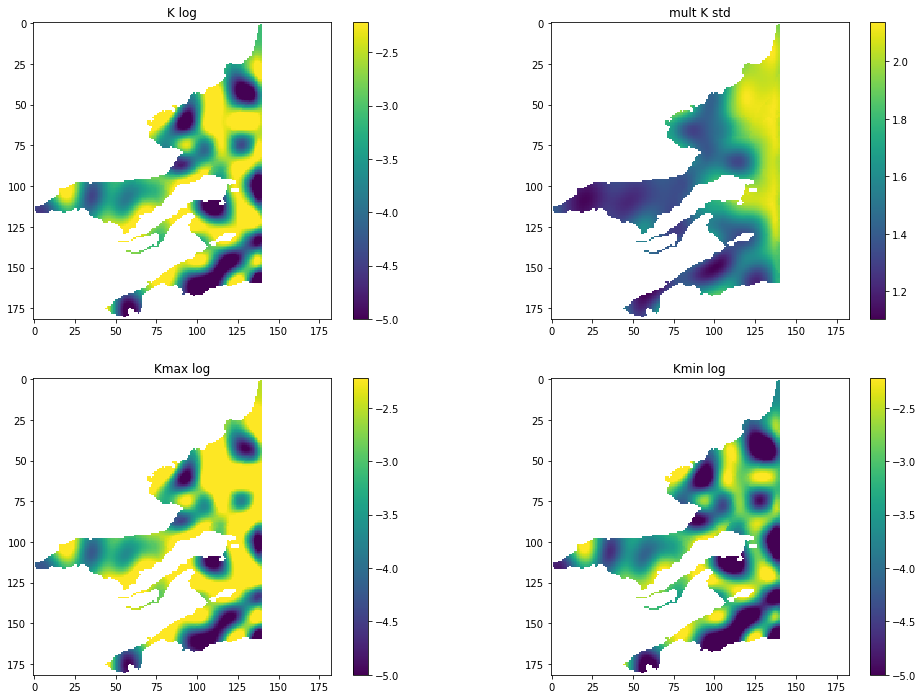

In [73]:
# inversion
fig,ax = plt.subplots(2,2,figsize=(17,12))
a1 = ax[0,0].imshow(kQ)
fig.colorbar(a1,ax=ax[0,0])
ax[0,0].set(title="K log")

a2 = ax[0,1].imshow(kQstd/2e-3)
fig.colorbar(a2,ax=ax[0,1])
ax[0,1].set(title="mult K std")

a3 = ax[1,0].imshow(np.log10(kQmax))
fig.colorbar(a3,ax=ax[1,0])
ax[1,0].set(title="Kmax log")

a4 = ax[1,1].imshow(np.log10(kQmin))
fig.colorbar(a4,ax=ax[1,1])
ax[1,1].set(title="Kmin log")


[Text(0.5, 1.0, 'Kmin log')]

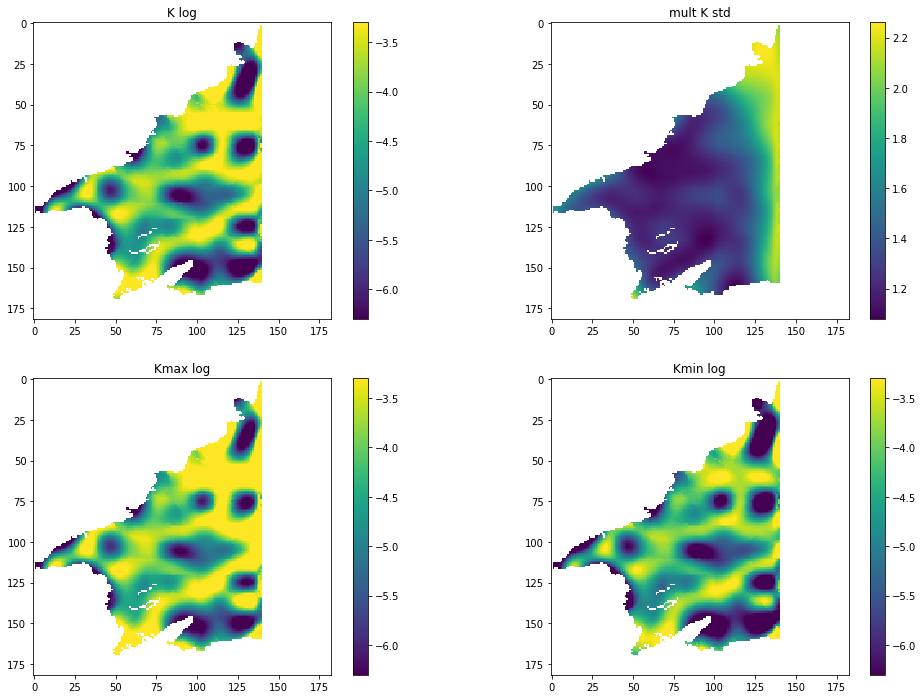

In [85]:
# inversion
fig,ax = plt.subplots(2,2,figsize=(17,12))
a1 = ax[0,0].imshow(np.log10(kP))
fig.colorbar(a1,ax=ax[0,0])
ax[0,0].set(title="K log")

a2 = ax[0,1].imshow(kPstd/1e-5)
fig.colorbar(a2,ax=ax[0,1])
ax[0,1].set(title="mult K std")

a3 = ax[1,0].imshow(np.log10(kPmax))
fig.colorbar(a3,ax=ax[1,0])
ax[1,0].set(title="Kmax log")

a4 = ax[1,1].imshow(np.log10(kPmin))
fig.colorbar(a4,ax=ax[1,1])
ax[1,1].set(title="Kmin log")

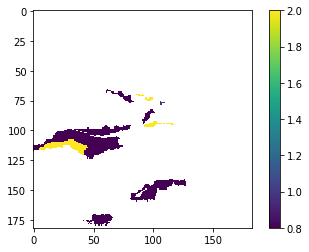

In [101]:
plt.imshow((np.loadtxt(os.path.join(t_d,"irr.txt"))/np.loadtxt(os.path.join("workspace","irr.txt"))))
plt.colorbar()

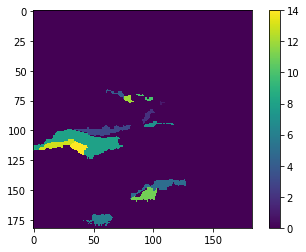

In [100]:
z_irr = np.loadtxt(os.path.join(t_d,"zone_irr.txt"))
# z_irr[z_irr!=10]=None
plt.imshow(z_irr)
plt.colorbar()

In [6]:
m_n_i = "pest_3d_r"
m_n = "PEST_3D_R"
sim = fp.mf6.MFSimulation.load(sim_ws="workspace")
m = sim.get_model(m_n_i)

grid = m.modelgrid

rivfiles = [os.path.splitext(riv)[0] for riv in os.listdir("workspace") if riv.endswith(".riv")]

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package wel...
    loading package rch...
    loading package rch...
    loading package rch...
    loading package wel...
    loading package chd...
    loading package chd...
    loading package drn...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package obs...
  loading ims package pest_3d_r...


C:\Users\emmal\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


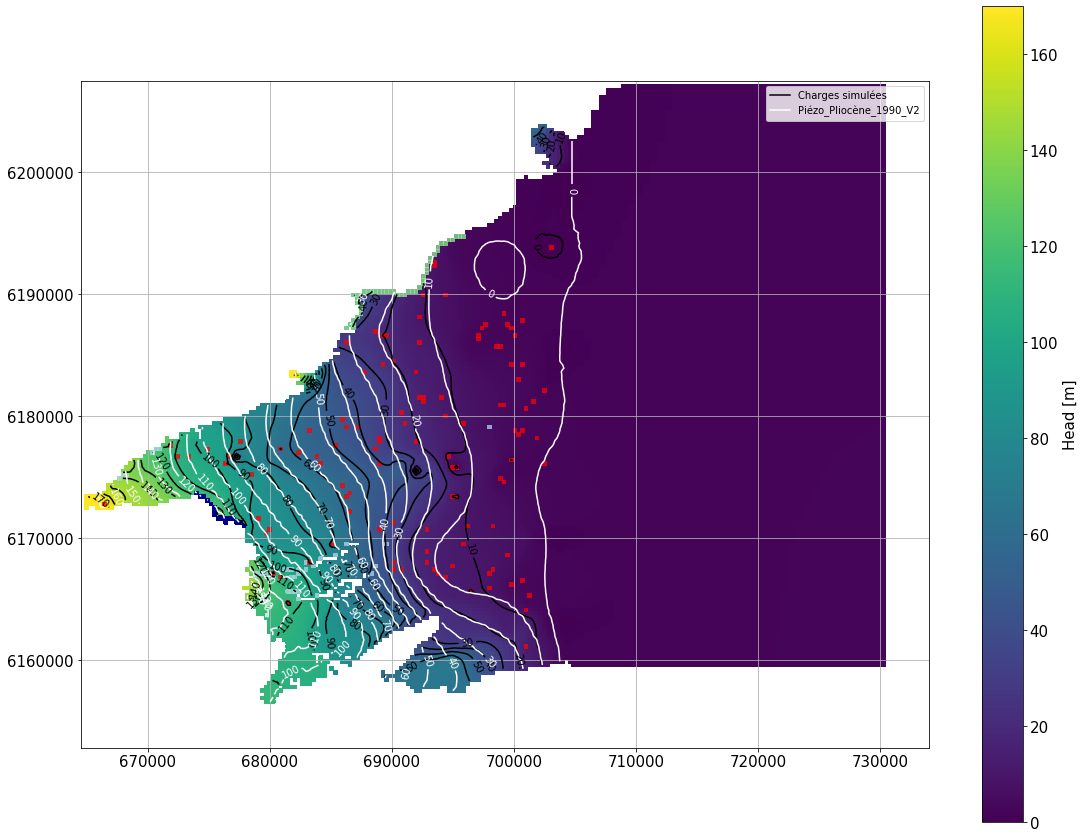

In [7]:
head = get_heads("pest_3D_R",t_d)

# initialize plot
fig = plt.figure(figsize=(19,15))
layer = 3
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=m,layer=layer)

#plot heads
hmesh = ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,170)
cont = ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,170,18),colors='black')
plt.clabel(cont,fmt="%1i")

##cont des mesures piézométriques
pz="../../data/cartes_pz/Piézo_Pliocène_1990_V2.grd"
rast = Raster.load(pz)
Mes_pz = rast.resample_to_grid(grid.xcellcenters,grid.ycellcenters,1)

Mes_pz[[head[layer]==1e30]]=None
cont_2=ml.contour_array(Mes_pz,levels=np.linspace(0,170,18),colors='white')
plt.clabel(cont_2,fmt="%1i")

#legend
proxy = [plt.Line2D((0,1),(0,0),color="black"),plt.Line2D((0,1),(0,0),color="white")]
plt.legend(proxy,["Charges simulées","{}".format(pz.split("/")[-1].split(".")[0])])

# plot bc
ml.plot_bc("sea",color="b",alpha=0.5)
for riv in rivfiles:
    ml.plot_bc(riv,color="lightblue",alpha=0.5)
ml.plot_bc("eta",color="b",alpha=0.5)
ml.plot_bc("wel",alpha=0.5)
ml.plot_bc("Corb",color="lightgreen",alpha=0.5)
ml.plot_bc("thuir",color="darkblue",alpha=1)

ax.tick_params(labelsize=15)

#colorbar
g = plt.colorbar(hmesh)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)

ax.grid()

In [79]:
top,botm,idomain,delr,delc = read_pickle(os.path.join("workspace","export_dis3D"))

In [80]:
#control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using ImportControlPz3D (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
geol_layer = ["Quaternaire","Pliocène"]
geol_col = "AquifèreCapté"
grid = fp.discretization.StructuredGrid(delc,delr,xoff =664525 ,yoff =6152875 )
nlay=5
Control_Pz = ImportControlPz3D(piez_path,sheet_name="2012",geol_layer=geol_layer,layer_num=[1,3],geol_col=geol_col,
                               grid=grid,nlay=nlay,np_col = "NP_Avril2013")

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [81]:
nrow=idomain.shape[1]
ncol=idomain.shape[2]

Misfit : 2.065657739606223 m 
MSE    : 12.544906571445164
φ      : 1530.47860171631


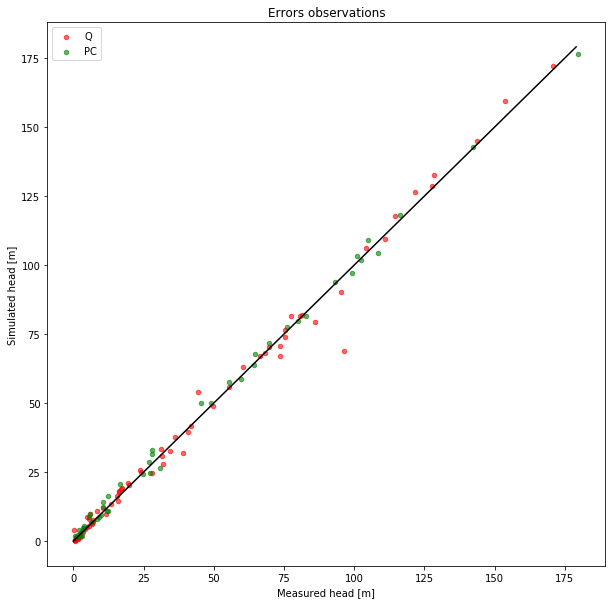

In [82]:
color = ["y","red","blue","green","black"]
label = ["sea","Q","inter","PC","PMS"]
fig = plt.figure(figsize=(10,10))

for ilay in [1,3]:
    Control_pz = Control_Pz[ilay].reshape(nrow*ncol)
    head_c = head[ilay].reshape(nrow*ncol)
    
    head_c[head_c>1000]=None
    if (Control_pz!=0).any():
        plt.scatter(Control_pz[Control_pz!=0],head_c[Control_pz!=0],s=20,c=color[ilay],label=label[ilay],alpha=0.6)
plt.legend()
plt.plot(np.arange(180),np.arange(180),"k")
plt.xlabel("Measured head [m]")
plt.ylabel("Simulated head [m]")
plt.title("Errors observations")

# stats
Control_pz = Control_Pz.reshape(nlay*nrow*ncol)
head_2 = head.reshape(nlay*nrow*ncol)
Misfit = np.abs((Control_pz[Control_pz!=0] - head_2[Control_pz!=0]))
MSE = np.nanmean((Control_pz[Control_pz!=0] - head_2[Control_pz!=0])**2)
phi = np.nansum((Control_pz[Control_pz!=0] - head_2[Control_pz!=0])**2)
print("Misfit : {} m ".format(np.nanmean(Misfit)))
print("MSE    : {}".format(MSE))
print("\u03C6      : {}".format(phi))